## Setup

### Variables to Edit

In [1]:
# enums
NORMAL, CATARACTS, MILD_AMBLYOPIA, MULTIPLE_SCLEROSIS = ['Normal', 'Cataracts', 'Mild Amblyopia', 'Multiple Sclerosis']

##################
# CUSTOMIZE HERE #
##################

# tasks and number of latents
phenotypes = [NORMAL, NORMAL]
num_latents = 2
sampling_method = 'alternating'     # 'alternating' or 'unconstrained'
weight_decay = 1e-4

# choose to run multiple experiments with preset random seeds
# or a single experiment specifying your own random seeds
run_multiple_experiments = False

if run_multiple_experiments:
    num_exps = 25
    # random seeds generated automatically
    # as [[0, 1], [2, 3], ... [2n, 2n+1]] for generating primer labels
    # and [0, ..., n-1] for starting the training loop
else:
    primer_random_seeds = [0, 0]
    gp_random_seed = 28
    # num_exps set to 1 later if running single round

# number of samples
num_halton_samples_per_task = 2
num_new_pts_per_task = 48


# runtime flags
verbose_mode = True         # print verbose analyses?
scrn_mode = True            # plot on screen?
save_results_mode = True    # save results to file?
save_plots_mode = True      # save plots to directory?

# choosing which figures to make
make_gp_gifs = True
make_entropy_gifs = False
make_hyper_plots = True


# directory to save plots and results
# will save to the path <save_dir_prefix>/<current_timestamp>
save_dir_prefix = 'analysis/Figure03'

# Individual print flags 
print_training_hyperparameters = False
print_training_iters = False
print_progress_bar = False

# Set all to true if verbose_mode
if verbose_mode:
    print_training_hyperparameters = False
    print_training_iters = True
    print_progress_bar = False

### Imports

In [2]:
# Import libraries
import os
import sys
import torch
import gpytorch as gp

import math
import numpy as np

import datetime
import json
import pickle
import tqdm

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.gridspec import GridSpec
import seaborn as sns

# need access to root directory to import utils
parent_dir = os.path.dirname(os.path.abspath(''))
if parent_dir not in sys.path:
    sys.path.append(parent_dir)
    
from utility.utils import *

Check versions of python, Gpytorch, and Pytorch dependencies

In [3]:
print("python version -->>", sys.version.split(" ")[0], "(expected 3.10.9)")
print("gpytorch version -->>", gp.__version__, "(expected 1.8.1)")
print("pytorch version -->>", torch.__version__, "(expected 1.13.1)")

python version -->> 3.10.9 (expected 3.10.9)
gpytorch version -->> 1.8.1 (expected 1.8.1)
pytorch version -->> 1.13.1 (expected 1.13.1)


### Misc Variables

In [4]:
# Constant Declarations

subplots_adjust_params = {
    'bottom':0.1, 
    'top':0.9, 
    'left':0.1, 
    'right':0.8, 
    'wspace':0.05, 
    'hspace':0.3
}
cax_location_params = [0.84, 0.1, 0.02, 0.8] # [left, bottom, width, height]

# Create the bounds for the data
raw_freq_min = 1
raw_freq_max = 64
raw_contrast_min = 1e-3
raw_contrast_max = 1

# Define how to transform the data
x_min = logFreq().forward(raw_freq_min)
x_max = logFreq().forward(raw_freq_max)
y_min = logContrast().forward(raw_contrast_max)  # max and min get flipped when inverting
y_max = logContrast().forward(raw_contrast_min)

# transform the data
def normalize_to_unit_range(d):
    return scale_data_within_range(d, (0, 1), x_min, x_max, y_min, y_max)

# marginal log resolutions of evaulation grid
x_resolution = 15  # 15 spatial frequencies per octave
y_resolution = 30  # 30 contrast units per decade

# for computing the proper prior threshold curve
psi_gamma  = 0.04  # guess rate is 4%
psi_lambda = 0.04 # lapse rate is 4%
psi_sigma = 0.08
sigmoid_type = 'logistic'

# training parameters?
num_initial_points_training_iters = 500
num_new_points_training_iters = 150
train_on_all_points_iters = 1500
sampling_strategy = 'active'
mean_module = 'constant_mean'
train_on_all_points_after_sampling = False
calculate_rmse = True
calculate_posterior = True
calculate_entropy = True

# GP hyperparameters?
learning_rate = .125
beta_for_regularization = .5
min_lengthscale = .15 # Note this changed from .2


# Set raw ghost points 
raw_ghost_frequency = np.array([1, 2, 4, 8, 16, 32, 64, 128])
raw_ghost_contrast = np.array([5e-4, 5e-4, 5e-4, 5e-4, 5e-4, 5e-4, 5e-4, 1])


In [5]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Prepare Data

### Get Data

In [6]:
# get data selection
exp1_file = '../data/raw/csf_curves_exp1.json'
csf_curves_exp1 = load_json_from_file(exp1_file)
all_phenotypes = {MULTIPLE_SCLEROSIS: csf_curves_exp1['multiple_sclerosis'],
             CATARACTS: csf_curves_exp1['cataracts'],
             NORMAL: csf_curves_exp1['normal'],
             MILD_AMBLYOPIA: csf_curves_exp1['mild_amblyopia']}

phenotype_pair = [(pheno, all_phenotypes[pheno]) for pheno in phenotypes]

### Set Timestamp to Save To

In [7]:
# get current timestamp
timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
save_dir = f"{save_dir_prefix}/{timestamp}/"
print(f"Saving to... {save_dir}")

Saving to... analysis/Figure03/2024-02-09_21-49-04/


### Calculate Common Variables

In [8]:
# create common variables shared among all tasks
grid, xx, yy, xs, ys = create_evaluation_grid_resolution(
        x_min, x_max, y_min, y_max, x_resolution, y_resolution)

grid_transformed = transform_dataset(grid, phi=normalize_to_unit_range)

# function to get ground truth curves
def get_spline(curve):
    curve = np.array(curve)
    curve[:, 0] = (np.log2(10) * curve[:, 0]) - np.log2(.125)
    cs = create_cubic_spline(curve)
    return cs

num_tasks = len(phenotype_pair)

ground_truths = [get_spline(pheno_data) for _, pheno_data in phenotype_pair]

# get number of actively learned points for disjoint vs conjoint
num_pts_per_task = num_new_pts_per_task + num_halton_samples_per_task
num_new_conjoint_pts = num_new_pts_per_task * num_tasks
num_conjoint_pts = num_pts_per_task * num_tasks

In [9]:
# create ghost points and labels
ghost_x1 = logFreq().forward(raw_ghost_frequency)
ghost_x2 = logContrast().forward(raw_ghost_contrast)
assert len(ghost_x1) == len(ghost_x2), "x1 and x2 have diff lengths"

ghost_X = np.vstack((ghost_x1, ghost_x2)).T
ghost_y = np.array([0]*len(ghost_x2))

# create disjoint initial primer points
halton_X = get_halton_samples(xx, yy, num_halton_samples_per_task)
initial_disjoint_X = np.vstack((ghost_X, halton_X))

# create conjoint initial primer points and task indices
# simulated Halton y labels are created later for each experiment
halton_Xs = np.repeat(halton_X, num_tasks, axis=0)

num_ghost_points_per_task = len(ghost_y)
halton_task_indices = torch.arange(num_tasks).tile((num_halton_samples_per_task))

ghost_Xs = np.tile(ghost_X, (num_tasks, 1))
ghost_ys = np.tile(ghost_y, num_tasks)
ghost_task_indices = torch.arange(num_tasks).repeat_interleave(num_ghost_points_per_task)

num_disjoint_ghost_points = len(ghost_x2)
num_conjoint_ghost_points = len(ghost_task_indices)

# create initial dataset using ghost and halton samples
initial_Xs = np.vstack((ghost_Xs, halton_Xs))
initial_task_indices = torch.cat((ghost_task_indices, halton_task_indices))

### Configure Multiple vs Single Experiments

In [10]:
# random seed lists for single vs multiple rounds
if run_multiple_experiments:
    # unique random seeds for halton samples and training
    primer_seeds_list = [(np.arange(num_tasks) + num_tasks*i).tolist() for i in range(num_exps)]
    gp_seed_list = [(np.arange(num_tasks) + num_tasks*i).tolist() for i in range(num_exps)]
else:
    num_exps = 1
    primer_seeds_list = [(np.arange(num_tasks) + num_tasks*i).tolist() for i in range(num_exps)]
    gp_seed_list = [(np.arange(num_tasks) + num_tasks*i).tolist() for i in range(num_exps)]

### Save Run Info to JSON

In [11]:
figure_dict = {
    "tasks": phenotypes,
    "num_latents": num_latents,
    "sampling_method": sampling_method,
    "num_exps": num_exps,
    "num_halton_samples_per_task": num_halton_samples_per_task,
    "num_new_pts_per_task": num_new_pts_per_task,
    "raw_freq_min": raw_freq_min,
    "raw_freq_max": raw_freq_max,
    "raw_contrast_min": raw_contrast_min,
    "raw_contrast_max": raw_contrast_max,
    "x_resolution": x_resolution,
    "y_resolution": y_resolution,
    "raw_ghost_frequency": raw_ghost_frequency.tolist(),
    "raw_ghost_contrast": raw_ghost_contrast.tolist(),
    "primer_seeds_list": primer_seeds_list,
    "gp_seed_list": gp_seed_list,
    "weight_decay": weight_decay,
    "min_lengthscale": min_lengthscale,
    "psi_sigma": psi_sigma,
    "sigmoid_type": sigmoid_type,
    "psi_gamma": psi_gamma,
    "psi_lambda": psi_lambda,
    "lr": learning_rate,
    "num_initial_training_iters": num_initial_points_training_iters,
    "num_new_points_training_iters": num_new_points_training_iters,
    "beta_for_regularization": beta_for_regularization,
    "train_on_all_points_after_sampling": train_on_all_points_after_sampling,
    "print_training_hyperparameters": print_training_hyperparameters,
    "print_training_iters": print_training_iters,
    "progress_bar": print_progress_bar,
    "calculate_rmse": calculate_rmse,
    "calculate_entropy": calculate_entropy,
    "calculate_posterior": calculate_posterior
}

ensure_directory_exists(save_dir)
with open(save_dir + "run_configs.json", 'w') as file:
    json.dump(figure_dict, file, indent=2)

## Model Training

### Disjoint

In [12]:
disjoint_results_dicts = [{} for _ in range(num_tasks)]
disjoint_gp_lists = []

for exp in range(num_exps):
    print(f"Experiment {exp}")

    # get unique random seeds for each exp
    primer_seeds = primer_seeds_list[exp]
    gp_seeds = gp_seed_list[exp]

    # get unique halton labels for each experiment
    halton_y_list = []
    
    for i, (pheno, pheno_data) in enumerate(phenotype_pair):
        print(pheno)
        
        cs = ground_truths[i]
        primer_seed = primer_seeds[i]
        gp_seed = gp_seeds[i]

        # get initial primer labels
        set_random_seed(primer_seed)
        halton_y = simulate_labeling(halton_X[:,0], halton_X[:,1], cs, 0, 0, sigmoid_type=sigmoid_type, psi_sigma=psi_sigma) # changed  psi_gamma, psi_lambda to 0, 0
        initial_y = np.hstack((ghost_y, halton_y))

        # run active learning
        set_random_seed(gp_seed)

        model, likelihood, X, y, rmse_list, _, posterior_list, _ = sample_and_train_gp(
            cs,
            grid,
            xx,
            yy,
            sampling_strategy=sampling_strategy,
            mean_module_name=mean_module,
            psi_sigma=psi_sigma,
            sigmoid_type=sigmoid_type,
            psi_gamma=psi_gamma,
            psi_lambda=psi_lambda,
            lr=learning_rate,
            num_initial_training_iters=num_initial_points_training_iters,
            num_new_points_training_iters=num_new_points_training_iters,
            num_new_points=num_new_pts_per_task,
            beta_for_regularization=beta_for_regularization,
            train_on_all_points_after_sampling=train_on_all_points_after_sampling,
            train_on_all_points_iters=train_on_all_points_iters,
            phi=normalize_to_unit_range,
            print_training_hyperparameters=print_training_hyperparameters,
            print_training_iters=print_training_iters,
            progress_bar=print_progress_bar,
            min_lengthscale=min_lengthscale,
            calculate_rmse=calculate_rmse,
            calculate_entropy=calculate_entropy,
            calculate_posterior=calculate_posterior,
            initial_Xs=initial_disjoint_X,
            initial_ys=initial_y,
            num_ghost_points=num_disjoint_ghost_points,
            weight_decay=weight_decay,
            kernel_config='new',
            acq_config='new'
        )


        zz = evaluate_posterior_mean(model, likelihood, grid_transformed) \
                .reshape(xx.shape)
                
        disjoint_results_dicts[i][exp] = {
            'training_seed': gp_seed,
            'random_seed': primer_seed,
            'X': X,
            'y': y,
            'zz': zz,
            'rmse_list': rmse_list
        }

        gp_list = [model for model, _ in posterior_list]
        disjoint_gp_lists.append(gp_list)
        print()

    if save_results_mode:
        ensure_directory_exists(save_dir)
        with open(f'{save_dir}disjoint_results.pkl', 'wb') as file:
            pickle.dump(disjoint_results_dicts, file)

Experiment 0
Normal
iteration 1/50


iteration 2/50
iteration 3/50
iteration 4/50
iteration 5/50
iteration 6/50
iteration 7/50
iteration 8/50
iteration 9/50
iteration 10/50
iteration 11/50
iteration 12/50
iteration 13/50
iteration 14/50
iteration 15/50
iteration 16/50
iteration 17/50
iteration 18/50
iteration 19/50
iteration 20/50
iteration 21/50
iteration 22/50
iteration 23/50
iteration 24/50
iteration 25/50
iteration 26/50
iteration 27/50
iteration 28/50
iteration 29/50
iteration 30/50
iteration 31/50
iteration 32/50
iteration 33/50
iteration 34/50
iteration 35/50
iteration 36/50
iteration 37/50
iteration 38/50
iteration 39/50
iteration 40/50
iteration 41/50
iteration 42/50
iteration 43/50
iteration 44/50
iteration 45/50
iteration 46/50
iteration 47/50
iteration 48/50
iteration 49/50
iteration 50/50

Normal
iteration 1/50
iteration 2/50
iteration 3/50
iteration 4/50
iteration 5/50
iteration 6/50
iteration 7/50
iteration 8/50
iteration 9/50
iteration 10/50
iteration 11/50
iteration 12/50
iteration 13/50
iteration 14/50
i

### Conjoint

In [13]:
conjoint_results_dicts = {}
conjoint_gp_lists = []

for exp in range(num_exps):
    print(f"Experiment {exp}")

    # get unique random seeds for each exp
    primer_seeds = primer_seeds_list[exp]
    gp_seed = gp_seed_list[exp][0]

    # get unique halton labels for each experiment
    halton_y_list = []
    
    for i, (pheno, pheno_data) in enumerate(phenotype_pair):
        cs = ground_truths[i]
        set_random_seed(primer_seeds[i])
        halton_y = simulate_labeling(halton_X[:,0], halton_X[:,1], cs, 0, 0, sigmoid_type=sigmoid_type, psi_sigma=psi_sigma)  # changed  psi_gamma, psi_lambda to 0, 0
        halton_y_list.append(halton_y)
    
    # stack all task halton labels then stack ghost with halton labels
    halton_ys = np.array([y for y_per_halton in zip(*halton_y_list) for y in y_per_halton])
    initial_ys = np.hstack((ghost_ys, halton_ys))

    # run active learning
    set_random_seed(gp_seed)

    model, likelihood, X, y, task_indices, rmse_list, entropy_list, posterior_list, _ = sample_and_train_gp_conjoint(
        cs=ground_truths,
        grid=grid,
        xx=xx,
        yy=yy,
        psi_sigma=psi_sigma,
        psi_gamma=psi_gamma,
        psi_lambda=psi_lambda,
        lr=learning_rate,
        num_initial_training_iters=num_initial_points_training_iters,
        num_new_points_training_iters=num_new_points_training_iters,
        num_new_points=num_new_conjoint_pts,
        beta_for_regularization=beta_for_regularization,
        phi=normalize_to_unit_range,
        print_training_hyperparameters=print_training_hyperparameters,
        print_training_iters=print_training_iters,
        train_on_all_points_after_sampling=train_on_all_points_after_sampling,
        train_on_all_points_iters=train_on_all_points_iters,
        min_lengthscale=min_lengthscale,
        initial_Xs=initial_Xs,
        initial_ys=initial_ys,
        sampling_strategy=sampling_strategy,
        num_ghost_points=num_conjoint_ghost_points,
        calculate_rmse=calculate_rmse,
        calculate_entropy=calculate_entropy,
        calculate_posterior=calculate_posterior,
        progress_bar=print_progress_bar,
        num_tasks=num_tasks,
        num_latents=num_latents,
        task_indices=initial_task_indices,
        sampling_method=sampling_method,
        weight_decay=weight_decay,
        kernel_config='new',
        acq_config='new'
    )

    zz = evaluate_posterior_mean(model, likelihood, grid_transformed) \
        .reshape((*xx.shape, num_tasks))

    conjoint_results_dicts[exp] = {
        'training_seed': gp_seed,
        'random_seeds': primer_seeds,
        'X': X,
        'y': y,
        'zz': zz,
        'task_indices': task_indices,
        'entropy_list': entropy_list,
        'rmse_list': rmse_list
    }

    gp_list = [model for model, _ in posterior_list]
    conjoint_gp_lists.append(gp_list)
    print()

    if save_results_mode:
        ensure_directory_exists(save_dir)
        with open(f'{save_dir}conjoint_results.pkl', 'wb') as file:
            pickle.dump(conjoint_results_dicts, file)

Experiment 0


iteration 1/100
iteration 2/100
iteration 3/100
iteration 4/100
iteration 5/100
iteration 6/100
iteration 7/100
iteration 8/100
iteration 9/100
iteration 10/100
iteration 11/100
iteration 12/100
iteration 13/100
iteration 14/100
iteration 15/100
iteration 16/100
iteration 17/100
iteration 18/100
iteration 19/100
iteration 20/100
iteration 21/100
iteration 22/100
iteration 23/100
iteration 24/100
iteration 25/100
iteration 26/100
iteration 27/100
iteration 28/100
iteration 29/100
iteration 30/100
iteration 31/100
iteration 32/100
iteration 33/100
iteration 34/100
iteration 35/100
iteration 36/100
iteration 37/100
iteration 38/100
iteration 39/100
iteration 40/100
iteration 41/100
iteration 42/100
iteration 43/100
iteration 44/100
iteration 45/100
iteration 46/100
iteration 47/100
iteration 48/100
iteration 49/100
iteration 50/100
iteration 51/100
iteration 52/100
iteration 53/100
iteration 54/100
iteration 55/100
iteration 56/100
iteration 57/100
iteration 58/100
iteration 59/100
itera

### Plotting variables

In [14]:
# Standard plotting Parameters

###########
# GENERAL #
###########

figure_width = 6.5  # inches
figure_height = 2 * (figure_width / 2 / 2)  # inches

dpi_val = 600              # graphics resolution
plt.rcParams['font.family'] = 'sans-serif'

# Colorblind friendly palette	
colors = sns.color_palette('colorblind', n_colors=12)  # colorblind friendly palette
col1=0; col2=1; col3=2; col4=4
mean_color = 'c'  # cyan
point_size = 20

legend_font_size = 8
legend_font_weight = 'roman'
tick_font_size = 8
tick_font_weight = 'roman'
label_font_size = 8
label_font_weight = 'roman'
title_font_size = 10
title_font_weight = 'roman'
suptitle_font_size = 16
suptitle_font_weight = 'roman'


x_tick_labels = [1, 4, 16, 64]
x_tick_values = logFreq().forward(np.array(x_tick_labels))
y_tick_labels = [1, 0.1, 0.01, 0.001]
y_tick_values = logContrast().forward(np.array(y_tick_labels))
cb_tick_labels = [0, 0.25, 0.5, 0.75, 1]
cb_tick_values = cb_tick_labels

cb_pad = 0.05  # move colorbar xx units horizontally
cb_label_pad = -58  # move colorbar label xx units horizontally

num_spline_vals = 100  # number of interpolated points in spline curves

color_map = 'gist_gray'
cb_tick_fontsize = 10
cb_label_fontsize = 12

x_label = 'Spatial Frequency (cyc/deg)'
y_label = 'Contrast'
cb_label = 'Detection Probability'

# marker dimensions
marker_size= 32            # marker size specified in pts
marker_line_width = .5        # line width specified in pts

latent_color = '#cf30cf'
mean_color = '#40E1D0'
success_color = 'blue'
failure_color = 'red'

linestyle = 'dashed'
dash_list = [(0, (10.0, 3.0))]
thresh_width = 2
num_curve_points = 1000

titles = {
    'disjoint': ('2nd Gen Disjoint', '2nd Gen Disjoint'),
    'conjoint': ('2nd Gen Conjoint', '2nd Gen Conjoint')
}

line_width = 1.5

## Main Plots

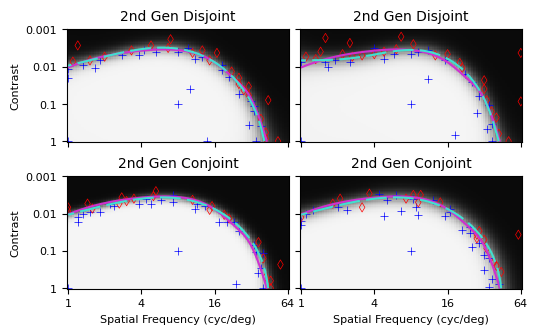

In [15]:
# plot final model for each experiment
for exp in range(num_exps):
    primer_seeds = primer_seeds_list[exp]

    # Create a 2x2 grid for subplots
    fig, axs = plt.subplots(2, num_tasks, figsize=(figure_width, figure_height))

    # create grid and posterior
    grid_transformed = transform_dataset(grid, phi=normalize_to_unit_range)

    # get experiment-specific data
    model = conjoint_gp_lists[exp][-1]
    X = conjoint_results_dicts[exp]['X']
    y = conjoint_results_dicts[exp]['y']
    task_indices = conjoint_results_dicts[exp]['task_indices']
    zz = conjoint_results_dicts[exp]['zz']

    for i, (pheno, _) in enumerate(phenotype_pair):
        ax = axs[1, i]
#         title = f"{pheno} cMLCRF2.0 (seed {primer_seeds[i]})"
        title = titles['conjoint'][i]

        # get posterior
        grid_indices = torch.from_numpy(np.repeat(i, grid_transformed.shape[0]).astype(np.int64))

        # get task-specific data
        task_X = X[task_indices == i, :]
        task_y = y[task_indices == i]
        task_zz = zz[:,:,i]
        ground_truth = ground_truths[i]

        # load data from results 
        conjoint_results_dict = {
            'X': task_X,
            'y': task_y,
            "xx": xx,
            "yy": yy,
            "zz": task_zz,
            "cs": ground_truth,
            "psi_gamma": psi_gamma,
            "psi_lambda": psi_lambda,
            "x_min": x_min,
            "x_max": x_max,
            "y_min": y_min,
            "y_max": y_max,
            "xs": xs,
            "ys": ys
        }

        create_gp_plot(
            ax, 
            conjoint_results_dict, 
            title,
            title_font_size=title_font_size,
            label_font_size=label_font_size,
            tick_font_size=tick_font_size,
            line_width=line_width,
            marker_size=marker_size,
            marker_line_width=marker_line_width
        )
        
        ax.label_outer()

    # create grid and posterior
    grid_transformed = transform_dataset(grid, phi=normalize_to_unit_range)

    # First Snippet Plotting in First Row
    for task_idx, (pheno, _) in enumerate(phenotype_pair):
        # get experiment-specific data from the first snippet
        model = disjoint_gp_lists[task_idx][-1]
        X = disjoint_results_dicts[task_idx][exp]['X']
        y = disjoint_results_dicts[task_idx][exp]['y']
        zz = disjoint_results_dicts[task_idx][exp]['zz']

        ax = axs[0, task_idx]
#         title = f"{pheno} dMLCRF2.0 (seed {primer_seeds[task_idx]})"
        title = titles['disjoint'][i]

        # load data from results 
        disjoint_results_dict = {
            'X': X,
            'y': y,
            "xx": xx,
            "yy": yy,
            "zz": zz,
            "cs": ground_truths[task_idx],
            "psi_gamma": psi_gamma,
            "psi_lambda": psi_lambda,
            "x_min": x_min,
            "x_max": x_max,
            "y_min": y_min,
            "y_max": y_max,
            "xs": xs,
            "ys": ys
        }

        create_gp_plot(
            ax, 
            disjoint_results_dict, 
            title,
            title_font_size=title_font_size,
            label_font_size=label_font_size,
            tick_font_size=tick_font_size,
            line_width=line_width,
            marker_size=marker_size,
            marker_line_width=marker_line_width
        )
        
        ax.label_outer()

    # overall figure settings
#     fig.suptitle(f"Disjoint vs Conjoint Experiment {exp}")
    plt.setp(axs, xticks=x_tick_values, xticklabels=x_tick_labels, yticks=y_tick_values, yticklabels=y_tick_labels)
    
    fig.subplots_adjust(**subplots_adjust_params)
    
    # TODO: Add a colorbar as needed

    # save and show
    if save_plots_mode:
        exp_details = "figure03"
        # Saving logic for the combined plot
        plt.savefig(f"{save_dir}Figure03_Disjoint2vsConjoint2.png", bbox_inches='tight', dpi=dpi_val)
        plt.savefig(f"{save_dir}Figure03_Disjoint2vsConjoint2.pdf", bbox_inches='tight', dpi=dpi_val)

    if scrn_mode:
        fig.show()
    else:
        plt.clf()


In [16]:
print("Disjoints:")
print(disjoint_results_dicts[0][0]['rmse_list'][-1])
print(disjoint_results_dicts[1][0]['rmse_list'][-1])
print("Conjoints:")
print(conjoint_results_dicts[0]['rmse_list'][0][-1])
print(conjoint_results_dicts[0]['rmse_list'][1][-1])

Disjoints:
0.04578782881856177
0.08619698697171584
Conjoints:
0.08772999751261822
0.08772999751261822
